In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver12.csv")
df2 = pd.read_csv("data/2026_FA예정_타자.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수 정의
def preprocess(df):
    df = df.copy()

    # 조건 필터링
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    # 컬럼 제거
    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # 선수명 기준 평균 후 중복 제거
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)

    return df

# 전처리 적용
df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_18328\1914192553.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


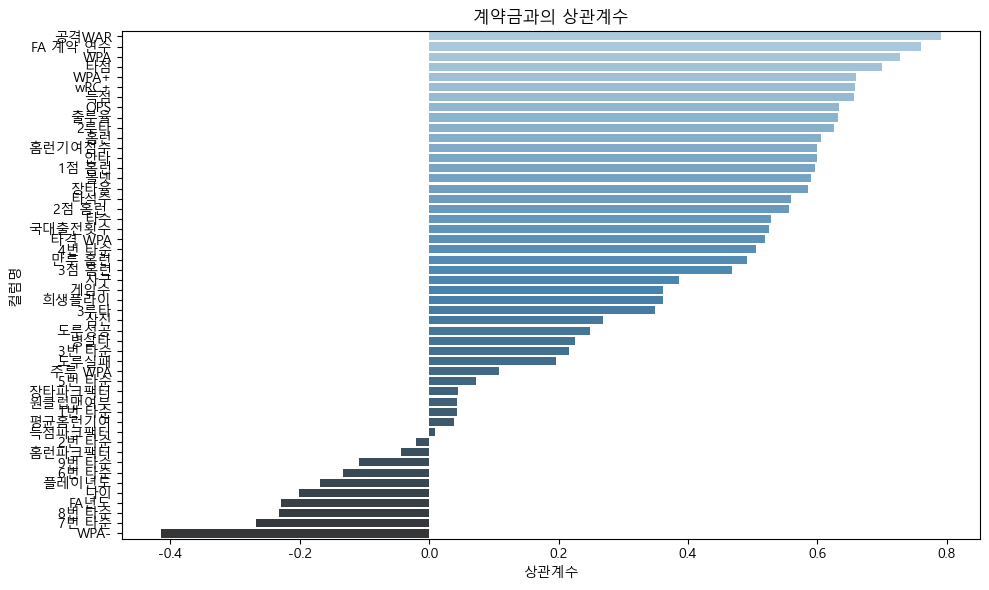

In [5]:
# 계약금과의 상관계수 계산
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)


# 한글 시각화 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 상관계수 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.ylabel('컬럼명')
plt.tight_layout()
plt.show()

In [6]:
# 상관계수 기반 가중치 계산
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})
print("상관계수 기반 가중치:")
print(weight_df)

# 예측에 사용할 공통 피처 추출
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
print(f"예측에 사용될 공통 피처: {predict_features}")

상관계수 기반 가중치:
         컬럼명       가중치
0      공격WAR  0.040855
1   FA 계약 연수  0.039275
2        WPA  0.037568
3         타점  0.036160
4       WPA+  0.034056
5       wRC+  0.033973
6         득점  0.033944
7        OPS  0.032738
8        출루율  0.032661
9        2루타  0.032353
10        홈런  0.031318
11    홈런기여점수  0.030976
12        안타  0.030939
13     1점 홈런  0.030799
14        볼넷  0.030449
15       장타율  0.030230
16       타석수  0.028906
17    2점 홈런   0.028724
18        타수  0.027303
19    국대출전횟수  0.027093
20    타격 WPA  0.026799
21     4번 타순  0.026125
22     만루 홈런  0.025381
23     3점 홈런  0.024150
24        사구  0.019909
25       게임수  0.018696
26     희생플라이  0.018636
27       3루타  0.018032
28        삼진  0.013870
29      도루성공  0.012825
30       병살타  0.011638
31     3번 타순  0.011183
32      도루실패  0.010136
33    주루 WPA  0.005569
34     5번 타순  0.003776
35    장타파크팩터  0.002330
36    원클럽맨여부  0.002259
37     1번 타순  0.002211
38    평균홈런기여  0.001993
39    득점파크팩터  0.000481
40     2번 타순  0.001028
41    홈런파크팩터  0.00222

In [7]:
# 학습 데이터 준비
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']

# 학습/검증 분할 + 스케일링 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(df2_cleaned[predict_features])

In [8]:
# CatBoost 모델 학습 (기본 파라미터)
cat_model = CatBoostRegressor(
    verbose=0,
    random_state=42
)
cat_model.fit(X_train_scaled, y_train)

In [9]:
# 검증 RMSE 출력
val_pred = cat_model.predict(X_val_scaled)
rmse = mean_squared_error(y_val, val_pred, squared=False)
print(f" [CatBoost] 검증 RMSE: {rmse:,.2f}")

# 예측 결과 저장
df2_cleaned['계약금'] = cat_model.predict(X_test_scaled)

 [CatBoost] 검증 RMSE: 174,021.81


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


피처 중요도 (CatBoost):
       컬럼명  중요도 (CatBoost)  상관계수 기반 가중치
17  국대출전횟수       16.274163     0.027093
0    공격WAR       14.539739     0.040855
4     wRC+        4.789991     0.033973
7      출루율        3.641833     0.032661
42      나이        3.234284     0.010384
14     장타율        3.053648     0.030230
8      2루타        2.894915     0.032353
5       득점        2.543227     0.033944
22      사구        2.419225     0.019909
2       타점        2.264557     0.036160
38  홈런파크팩터        2.144663     0.002225
41   플레이년도        2.128373     0.008669
15     타석수        1.992345     0.028906
27    도루성공        1.991169     0.012825
26      삼진        1.897124     0.013870
25     3루타        1.705646     0.018032
1      WPA        1.673274     0.037568
33  장타파크팩터        1.564533     0.002330
19   4번 타순        1.499203     0.026125
10  홈런기여점수        1.430851     0.030976
31  주루 WPA        1.414989     0.005569
29   3번 타순        1.406529     0.011183
11      안타        1.379532     0.030939
20   만루 홈런        1.3

C:\Users\Lee\AppData\Local\Temp\ipykernel_18328\2544879731.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='중요도 (CatBoost)', y='컬럼명', palette='YlGn_r')


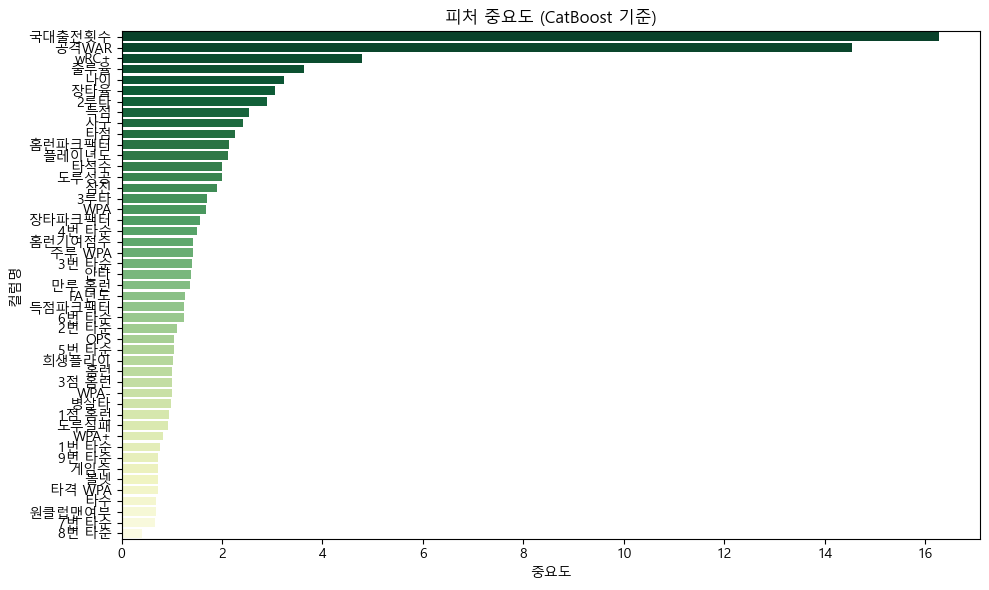

In [10]:
# 피처 중요도 정리
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (CatBoost)': cat_model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (CatBoost)', ascending=False)

print("피처 중요도 (CatBoost):")
print(importance_df)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='중요도 (CatBoost)', y='컬럼명', palette='YlGn_r')
plt.title('피처 중요도 (CatBoost 기준)')
plt.xlabel('중요도')
plt.ylabel('컬럼명')
plt.tight_layout()
plt.show()

In [11]:
# 예측 결과 확인
print("예측 계약금 상위 선수 (CatBoost):")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='계약금', ascending=False))

예측 계약금 상위 선수 (CatBoost):
    선수명            계약금
0   강민호  222632.999506
13  최형우  217433.546419
2   김재환  210040.694455
3   박병호  192801.891613
6   박해민  184305.647937
7   손아섭  167990.370063
14  황재균  155061.078261
1   강백호  154041.726386
5   박찬호  153628.804346
12  최원준  130242.776423
9   장성우  129646.837343
8   이재원   83557.299968
11  조수행   69189.140485
4   박승욱   46412.431657
10   정훈   34689.601426
